In [1]:
import sys
import math
import ROOT
from ROOT import kBlack,kWhite,kGray,kRed,kPink,kMagenta,kViolet,kBlue,kAzure,kCyan,kTeal,kGreen,kSpring,kYellow,kOrange,kDashed,kSolid,kDotted
from ROOT import gSystem, gROOT, TCanvas, TGraphErrors, TMultiGraph, TF1, gStyle, kRed, kBlue, kGray, TFile, TTree, TPad, gPad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psyplot.project as psy
import seaborn as sns
print("Python version")
print (sys.version)
import uproot

# Setting up the ATLAS style
ROOT.gROOT.LoadMacro("/Users/jordi/code/AtlasStyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/Users/jordi/code/AtlasStyle/AtlasUtils.C")
ROOT.SetAtlasStyle()

def prepare_graph(graph, name, title, colour = 9, markerStyle = 21, factor = 1):
   # graph settings
   graph.SetTitle(title)
   graph.SetName(name)
   graph.SetMarkerStyle(markerStyle)
   graph.SetMarkerSize(1.4)
   graph.SetMarkerColor(colour)
   graph.SetLineColor(colour)
   # set Y axis
   graph.GetYaxis().SetTitleSize(0.06)
   graph.GetYaxis().SetTitleOffset(1.1)
   graph.GetYaxis().SetLabelSize(0.045)
   graph.GetYaxis().SetNdivisions(504)
   # set X axis
   graph.GetXaxis().SetTitleSize(0.07)
   graph.GetXaxis().SetTitleOffset(1.)
   graph.GetXaxis().SetLabelSize(0.05)
   graph.GetYaxis().SetNdivisions(506)




Welcome to JupyROOT 6.26/06
Python version
3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]

Applying ATLAS style settings...



In [2]:
qToGeV = (6250 * 3.6) / (1.e9)
threshold = 2 # threshold on the pixels in fC
upperThreshold = 64 # upper threshold on the pidxels in fC
#upperThreshold = 1000 # upper threshold on the pidxels in fC
#files = ["1GeV_"+particle,"10GeV_"+particle,"100GeV_"+particle,"500GeV_"+particle,"1000GeV_"+particle]
energy = "100"
energies = ['1','10','50','100','250','500','1000','2000','3500']
#energies = ['1','10','50','100']
files_tmp = []
nFiles = 10
files = []
for ie in energies:    
    files_tmp = []
    for i in range(nFiles):
        files_tmp.append(ie+"GeV_preshowerUpgrade_calo_1000events_"+str(i+1))
    files.append(files_tmp)
file_shape = np.shape(files)
print('file shape ',file_shape)
# create an empty 2D list. We are going to store the pandas dataframes here
pds = np.empty(shape=file_shape+(0,)).tolist()
#for ifile, filename in enumerate(files):
for x in range(len(files)):
    for y in range(len(files[x])):
        print('Opening '+files[x][y],end=' \n')
        energy = int(files[x][y].split('GeV')[0])
        #print('energy '+str(energy)+' GeV')
        path = "/Users/jordi/code/samples/resolution/geant4/"
        fileName = path+files[x][y]+".root"
        ufile = uproot.open(fileName)
        treeName = "hits"
        tree = ufile[treeName]
        event = tree.arrays(["event","QfC","x","y","z","Edep_Sci_calo","siliconHits_ID"], library="pd",entry_stop=-1)
        #pixels = event.groupby(['siliconHits_ID','event','x','y','Edep_Sci_calo'],as_index=False)['QfC'].sum()
        # add all charges corresponding to a given pixel for a given event
        pixels=event.groupby(['event','x','y','z','Edep_Sci_calo']).agg({'QfC':'sum'})
        # filter the events to have pixel charge > 1 fC
        pixels_1fC = pixels[pixels['QfC'] > threshold]
        pixels_1fC = pixels_1fC[pixels_1fC['QfC'] < upperThreshold]
        #print(pixels_1fC)
        # as_index = false keeps the name of the summed column (in this case QfC)
        pixels_1fC = pixels_1fC.groupby(['event','Edep_Sci_calo'])['QfC'].sum().reset_index(name ='QfC')
        #print(pixels_1fC.head())
        # convert all charges in fC to energy in GeV
        pixels_1fC.loc[:,'QfC'] *= qToGeV
        #print('filling ',[x],[y])
        pds[x][y] = pixels_1fC



file shape  (9, 10)
Opening 1GeV_preshowerUpgrade_calo_1000events_1 
Opening 1GeV_preshowerUpgrade_calo_1000events_2 
Opening 1GeV_preshowerUpgrade_calo_1000events_3 
Opening 1GeV_preshowerUpgrade_calo_1000events_4 
Opening 1GeV_preshowerUpgrade_calo_1000events_5 
Opening 1GeV_preshowerUpgrade_calo_1000events_6 
Opening 1GeV_preshowerUpgrade_calo_1000events_7 
Opening 1GeV_preshowerUpgrade_calo_1000events_8 
Opening 1GeV_preshowerUpgrade_calo_1000events_9 
Opening 1GeV_preshowerUpgrade_calo_1000events_10 
Opening 10GeV_preshowerUpgrade_calo_1000events_1 
Opening 10GeV_preshowerUpgrade_calo_1000events_2 
Opening 10GeV_preshowerUpgrade_calo_1000events_3 
Opening 10GeV_preshowerUpgrade_calo_1000events_4 
Opening 10GeV_preshowerUpgrade_calo_1000events_5 
Opening 10GeV_preshowerUpgrade_calo_1000events_6 
Opening 10GeV_preshowerUpgrade_calo_1000events_7 
Opening 10GeV_preshowerUpgrade_calo_1000events_8 
Opening 10GeV_preshowerUpgrade_calo_1000events_9 
Opening 10GeV_preshowerUpgrade_calo_100

In [3]:
import pandas as pd
# now we are going to concatenate all the panda dataframes corresponding to the same energy and put them in a list
pixels_1fC = []
for x in range(len(files)):
    pixels_1fC_tmp = pd.DataFrame()
    for y in range(len(files[x])):
        pixels_1fC_tmp = pd.concat([pixels_1fC_tmp,pds[x][y]])
    pixels_1fC.append(pixels_1fC_tmp)
print(np.shape(pixels_1fC))
#pixels_1fC.plot(kind='hexbin', x='QfC', y='Edep_Sci_calo', gridsize=60, figsize=(10,6))

#print(pixels_1fC[6][996:1010])
#print(pixels_1fC[6].max())

(9,)


/opt/homebrew/Caskroom/miniforge/base/envs/env_root_root6.26.06/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [4]:
import hist
file = uproot.recreate("th2_"+str(threshold)+"fC.root")
histos = []
xmin = []
xmax = []
ymin = []
ymax = []
for i in range(len(pixels_1fC)):
    QfC = pixels_1fC[i]['QfC'].to_numpy()
    Edep_Sci_calo = pixels_1fC[i]['Edep_Sci_calo'].to_numpy()
    xmin.append(QfC.min())
    xmax.append(QfC.max())
    ymin.append(Edep_Sci_calo.min())
    ymax.append(Edep_Sci_calo.max())
    print('xmax = ', xmax[i])
    bins = 100
    #print(QfC.min(),QfC.max())
    hist2d = hist.Hist(hist.axis.Regular(bins, xmin[i], xmax[i], name="Q [fC]"), hist.axis.Regular(bins, ymin[i], ymax[i], name="E_{calo} [GeV]"))
    hist2d.fill(QfC, Edep_Sci_calo)
    outName = "hist_2d_"+energies[i]+"GeV"
    file[outName] = hist2d
    histos.append(outName)



xmax =  0.0009825974948859779
xmax =  0.003449611378315033
xmax =  0.009815477608463538
xmax =  0.015444930048915003
xmax =  0.029110238777902316
xmax =  0.04988414160325444
xmax =  0.09123084246557216
xmax =  0.15971104092207689
xmax =  0.2490992900792492


In [5]:
def prepare_th2(th2,titlex, titley, titlez):
   #th2.SetTitleOffset(1.0)
   th2.GetXaxis().SetTitleOffset(1.3)
   #th2.GetZaxis().SetLabelSize(0.03);
   th2.GetZaxis().SetLabelSize(0.04)
   th2.GetXaxis().SetLabelSize(0.04)
   th2.GetYaxis().SetLabelSize(0.04)
   th2.GetXaxis().SetTitle(titlex)
   th2.GetYaxis().SetTitle(titley)
   th2.GetZaxis().SetTitle(titlez)

f = ROOT.TFile("th2_"+str(threshold)+"fC.root","READ")
gSlope = TGraphErrors() 
gConst = TGraphErrors() 
for ihisto, histoname in enumerate(histos):
   hist2d = f.Get("hist_2d_"+energies[ihisto]+"GeV")
   prof = hist2d.ProfileX()
   #xmin_fit = (xmin[ihisto] + xmax[ihisto])/8
   #xmax_fit = xmax[ihisto] - xmax[ihisto] * 0.15
   xmin_fit = (xmin[ihisto] + xmax[ihisto])/6
   xmax_fit = xmax[ihisto] - xmax[ihisto] * 0.2
   fitReso_pol = TF1("finalPol", "pol1", xmin_fit, xmax_fit)
   fitReso_pol.SetLineColor(kRed)
   fitReso_pol.SetLineWidth(1)
   #result_pol = prof.Fit(fitReso_pol, "SRN")
   result_pol = prof.Fit(fitReso_pol, "SRQ")
   chi2ndf = fitReso_pol.GetNDF()/fitReso_pol.GetChisquare()
   print(chi2ndf)
   #result_pol = prof.Fit(fitReso_pol, "SRNEM")
   c_reso = ROOT.TCanvas("c_reso", "", 700, 600)
   c_reso.cd()
   gStyle.SetOptFit(1111)
   gPad.SetRightMargin(0.17)
   prepare_th2(hist2d, "E_{Si} [GeV]", "E_{calo} [GeV]", "Events")
   
   #fitReso_pol.GetFunction("pol1").SetLineColor(kRed)
   hist2d.Draw("COLZ")
   prof.Draw("same")
   fitReso_pol.Draw("same")

   leg =  ROOT.TLegend(0.5,0.85,0.7,0.90)
   leg.SetFillStyle(0)
   leg.SetFillColor(0)
   leg.SetBorderSize(0)
   leg.SetTextFont(42)
   leg.SetTextSize(0.035)

   leg.AddEntry(fitReso_pol,"pol fit: #chi^{2}/N_{DF} = "+str(round(chi2ndf,2)),"l")
   leg.Draw()
   c_reso.SaveAs("plots/th2_"+energies[ihisto]+"_"+str(threshold)+"fC.pdf")
   
   const = result_pol.Get().Parameter(0)
   dconst = result_pol.Get().Error(0)
   slope = result_pol.Get().Parameter(1)
   slopeError = result_pol.Get().Error(1)

   gSlope.SetPoint(ihisto, int(energies[ihisto]), slope)
   gSlope.SetPointError(ihisto, 0, slopeError)
   print('slope = ', slope)
   gConst.SetPoint(ihisto, int(energies[ihisto]), const)
   gConst.SetPointError(ihisto, 0, dconst)

   # save also the profiles in the file with the histograms
   prof.Write()
   
c_slope = ROOT.TCanvas("c_slope", "", 700, 600)
c_slope.cd()
prepare_graph(gSlope, "slope", ";E_{beam} [GeV];Slope", kRed+1, 21)
prepare_graph(gConst, "const", ";E_{beam} [GeV];Const [GeV]", kRed+1, 21)
gSlope.Draw()
c_slope.SaveAs("plots/slope_"+str(threshold)+"fC.pdf")
c_slope.Close()
# save the plots in a file
plots = TFile("slope_"+str(threshold)+"fC.root","RECREATE")
gSlope.Write()
gConst.Write()
plots.Write()
plots.Close()


0.9170512644655576
slope =  -17.65958811924605
0.08675669333666818
slope =  -155.07688038913173
0.11721641359916239
slope =  -476.81963212388814
0.18159103917903066
slope =  -539.8080139326605
0.6866825598586157
slope =  -541.8606508465394
1.0079401997721147
slope =  -492.48676582702944
1.070096860345135
slope =  -430.9302592574497
0.9033176229737593
slope =  -384.23126863628545
1.1363191697101398
slope =  -342.7263898878857


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <TCanvas::Print>: pdf file plots/th2_1_2fC.pdf has been created
Error in <TFile::WriteTObject>: Directory th2_2fC.root is not writable
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_reso
Info in <TCanvas::Print>: pdf file plots/th2_10_2fC.pdf has been created
Error in <TFile::WriteTObject>: Directory th2_2fC.root is not writable
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_reso
Info in <TCanvas::Print>: pdf file plots/th2_50_2fC.pdf has been created
Error in <TFile::WriteTObject>: Directory th2_2fC.root is not writable
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_reso
Info in <TCanvas::Print>: pdf file plots/th2_100_2fC.pdf has been created
Error in <TFile::WriteTObject>: Directory th2_2fC.root is not writable
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_reso
Info in <TCanvas::Print>: pdf file plots/th2_250_2fC.pdf

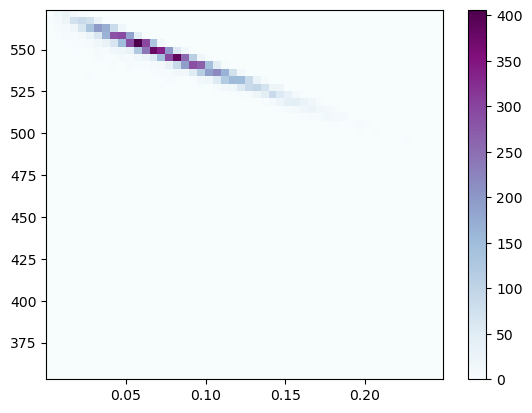

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 2., 3., 3.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([9.93493284e-05, 2.58934874e-03, 5.07934814e-03, 7.56934755e-03,
        1.00593470e-02, 1.25493464e-02, 1.50393458e-02, 1.75293452e-02,
        2.00193446e-02, 2.25093440e-02, 2.49993434e-02, 2.74893428e-02,
        2.99793422e-02, 3.24693416e-02, 3.49593410e-02, 3.74493404e-02,
        3.99393398e-02, 4.24293393e-02, 4.49193387e-02, 4.74093381e-02,
        4.98993375e-02, 5.23893369e-02, 5.48793363e-02, 5.73693357e-02,
        5.98593351e-02, 6.23493345e-02, 6.48393339e-02, 6.73293333e-02,
        6.98193327e-02, 7.23093321e-02, 7.47993316e-02, 7.72893310e-02,
        7.97793304e-02, 8.22693298e-02, 8.47593292e-02, 8.72493286e-02,
        8.97393280e-02, 9.22293274e-02, 9.47193268e-02, 9.72093262e-02,
        9.96993256e-02, 1.02189

In [6]:
# convert pandas column to numpy array
plt.hist2d(QfC, Edep_Sci_calo, bins=(50, 50), cmap=plt.cm.BuPu)# cmap="Greens")
plt.colorbar()
plt.show()
#sns.jointplot(x=QfC, y=Edep_Sci_calo, kind="kde")
sns.jointplot(x=QfC, y=Edep_Sci_calo, kind="reg")
#sns.kdeplot(x=QfC, y=Edep_Sci_calo, cmap="Reds", shade=True)#cbar=True)#  shade_lowest=False)

ax1 = sns.jointplot(x=QfC, y=Edep_Sci_calo,kind="reg")
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)
plt.hist2d(QfC, Edep_Sci_calo, bins=(100, 100), cmap=plt.cm.BuPu)

In [7]:
n = 10000

x = np.linspace(1, 100, n)

y = 2*np.log(x) + np.random.rand(n) - 0.5

# Compute 2d histogram. Note the order of x/y and xedges/yedges

H, yedges, xedges = np.histogram2d(y, x, bins=20)

In [8]:
import sys
import math
import ROOT
from ROOT import kBlack,kWhite,kGray,kRed,kPink,kMagenta,kViolet,kBlue,kAzure,kCyan,kTeal,kGreen,kSpring,kYellow,kOrange,kDashed,kSolid,kDotted
from ROOT import gSystem, gROOT, TCanvas, TGraphErrors, TMultiGraph, TF1, gStyle, kRed, kBlue, kGray, TFile, TTree, TPad, gPad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def prepare_th2(th2,titlex, titley, titlez):
   #th2.SetTitleOffset(1.0)
   th2.GetXaxis().SetTitleOffset(1.3)
   #th2.GetZaxis().SetLabelSize(0.03);
   th2.GetZaxis().SetLabelSize(0.04)
   th2.GetXaxis().SetLabelSize(0.04)
   th2.GetYaxis().SetLabelSize(0.04)
   th2.GetXaxis().SetTitle(titlex)
   th2.GetYaxis().SetTitle(titley)
   th2.GetZaxis().SetTitle(titlez)
f = ROOT.TFile("slope_"+str(threshold)+"fC.root","READ")
gSlope = TGraphErrors()
hist2d = f.Get("hist_2d_10GeV")
prof = hist2d.ProfileX()
fitReso_pol = TF1("finalPol", "pol1", 0.0, 1.)
#print(xmin[ihisto], xmax[ihisto])
#result_pol = prof.Fit(fitReso_pol, "SRN")
result_pol = prof.Fit(fitReso_pol, "SR")
#result_pol = prof.Fit(fitReso_pol, "SRNEM")
c_reso = ROOT.TCanvas("c_reso", "", 700, 600)
c_reso.cd()
gStyle.SetOptFit(1111)
gPad.SetRightMargin(0.17)
prepare_th2(hist2d, "E_{Si} [GeV]", "E_{calo} [GeV]", "Events")
hist2d.Draw("COLZ")
prof.Draw("same")
fitReso_pol.Draw("same")
c_reso.Draw()
#c_reso.SaveAs("plots/test.pdf")

AttributeError: 'TObject' object has no attribute 'ProfileX'